# Linear Gaussian State Space Model

As a first approach to the problem of choosing a proposal for Sequential Monte Carlo (SMC), let's consider a simple linear gaussian state space model. This way, it will be possible to compare obtained results to those provided by a Kalman filter.

We will consider the following model: 
$$
\begin{array}{l}
X_{t+1} = A X_t + W_t\\
Y_{t+1} = B X_t + V_t
\end{array}
$$
where $\ W_t \sim \mathcal{N}(0,Q) \ \textrm{and} \ V_t \sim \mathcal{N}(0, R)$. Our interest is to estimate the latent variables $X_{1:T}$.

First, we will consider a one-dimensional generated dataset.

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import distributions
from torch.distributions import Normal
from torch import nn
from scipy.special import logsumexp
from tqdm import tqdm
import math

In [2]:
# Reading data
with open("./data/gaussian_ssm_data1.txt", "r") as f:
    lines = f.readlines()
    Y = [float(i) for i in lines[1].split(',')[1:]]

In [5]:
y = Y[-10:] # trying to make this work T-T

## Kalman Filter

The first approach to be consider is the Kalman filter, which is implemented by the code bellow, following the procedure described by \[1\].

In [6]:
def KalmanFilter(Y, A, B, Q, R, x0, P0):
    '''
    Implements the Kalman Filter.
    ---
    >> Y: observed data (list)
    >> A: state transition matrix (np.array)
    >> B: observation matrix (np.array)
    >> Q: process noise covariance (np.array)
    >> R: observation noise covariance (np.array)
    >> x0: initial state estimate
    >> P0: initial covariance estimate
    '''

    # Initial estimates
    P = P0
    x_hat = x0

    D = P0.shape[0]  # Dimension
    
    estimates = []
    
    for y_t in Y:
        # Project into t+1
        x_ = A @ x_hat
        P_ = A @ P @ A.T + Q
        
        # Kalman Gain
        S = B @ P_ @  B.T + R
        K = P_ @ B.T @ np.linalg.inv(S)
        
        # Update Estimate
        innovation = y_t - B @ x_
        x_hat = x_ + K @ innovation 

        # Update Covariance
        P = (np.eye(D) - K @ B) @ P_

        estimates.append(x_hat)

    return np.array(estimates).reshape(len(estimates))

In [7]:
X_hat = KalmanFilter(Y, 
                     np.array([[0.75]]), 
                     np.array([[0.5]]), 
                     np.array([[1]]),
                     np.array([[1]]), 
                     np.array([0]),    # educated guess
                     np.array([[10]])  # high variance, because the guess is probably wrong
                    )

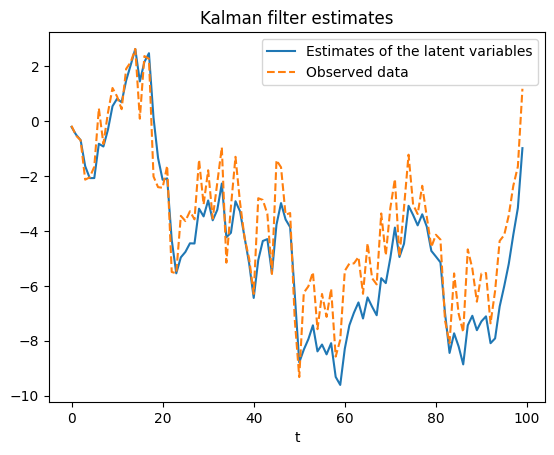

In [8]:
plt.plot(X_hat, label='Estimates of the latent variables')
plt.plot(Y, ls='--',label='Observed data')
plt.xlabel("t")
plt.title("Kalman filter estimates")
plt.legend()

In [9]:
def SMC_with_prior(y, N=1000):
    '''
    aaaaaaaaaaaaaaaaaaaaaaaa
    ---
    '''
    T = len(y)
        
    # Storage for particles and weights
    x = [[] for _ in range(N)]       # list of particle trajectories
    w = np.zeros((T, N))             # weights: shape [T x N]
    a = np.zeros((T, N), dtype=int)  # ancestry indices
    
    # Initialization: t = 1
    for i in range(N):
        x_i = Normal(0,1).sample() #proposal(params, None).sample()  # simulate x_1 from r(x_1; λ)
        x[i].append(x_i)
            
        # Compute log weights
        # cur_w = Normal(0,1).log_prob(x_i)                    # prior 
        # cur_w += Normal(x_i,1).log_prob(torch.tensor(y[0]))  # likelihood 
        # cur_w -= proposal(params, None).log_prob(x_i)                # proposal
        w[0, i] = Normal(x_i,1).log_prob(torch.tensor(y[0]))#cur_w #.exp()
    
    # Normalize weights
    # w[0] /= np.sum(w[0])
    prob_choice = np.exp(w[0] - logsumexp(w[0])) #w[0]/np.sum(w[0])
    
    # Sequential steps: t = 2 to T
    for t in range(1, T):
        x_new = [[] for _ in range(N)]
        for i in range(N):
            # Resample ancestor index according to weights
                
            a_t = np.random.choice(N, p = prob_choice)
            a[t, i] = a_t
    
            # Simulate x_t from r(x_t | x_{t-1}; λ)
            x_t = Normal(x[a_t][-1], 1).sample()# proposal(params, x[a_t][-1]).sample()
                
            # Set new trajectory x_{1:t}
            x_new[i] = x[a_t][:] + [x_t]
    
            # Compute weight
            # cur_w = Normal(x_new[i][-1], 1).log_prob(x_t)      # prior 
            # cur_w += Normal(x_t, 1).log_prob(torch.tensor(y[t]))      # likelihood 
            # cur_w -= proposal(params, x[a_t][-1]).log_prob(x_t)  # proposal
            w[t, i] =  Normal(x_t, 1).log_prob(torch.tensor(y[t])) #cur_w.exp()
    
        x = x_new
        prob_choice = np.exp(w[t] - logsumexp(w[t])) #w[t]/np.sum(w[t])
        # w[t] /= np.sum(w[t])  # normalize weights
    
    # Final selection
    b_T = np.random.choice(N, p = prob_choice)
    x_T = x[b_T]
    
    return x_T, w


In [10]:
y

[-5.553365553390475,
 -5.5340935309638395,
 -7.367154223508493,
 -6.183979174651755,
 -4.363064788464792,
 -4.14850409348519,
 -3.431289309575484,
 -2.3522075530402065,
 -1.65127340025697,
 1.1818644252707111]

In [13]:
x_prior, w_prior = SMC_with_prior(Y)

(0.0, 1000.0)

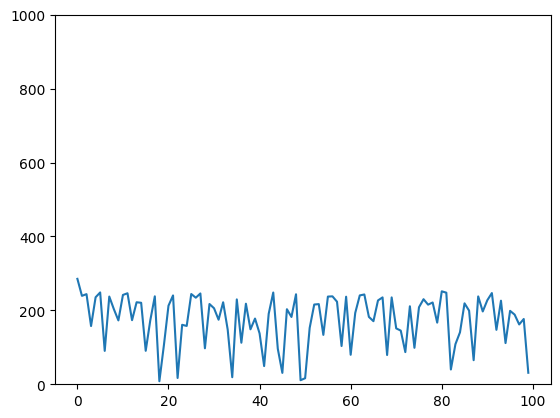

In [14]:
ESS_prior = np.exp(2*logsumexp(w_prior, axis=1)-logsumexp(w_prior,axis=1))
plt.plot(ESS_prior)
plt.ylim((0,1000))

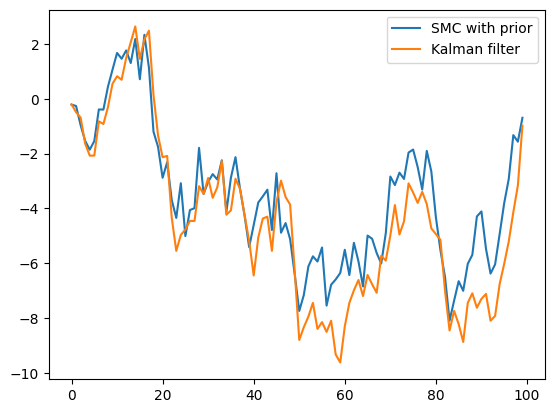

In [15]:
plt.plot(torch.tensor(x_prior).numpy(), label="SMC with prior")
plt.plot(X_hat, label='Kalman filter')
plt.legend()

In [ ]:
def SMC_optimal(y, N=100):
    '''
    aaaaaaaaaaaaaaaaaaaaaaaa
    ---
    '''
    T = len(y)
        
    # Storage for particles and weights
    x = [[] for _ in range(N)]       # list of particle trajectories
    w = np.zeros((T, N))             # weights: shape [T x N]
    a = np.zeros((T, N), dtype=int)  # ancestry indices
    
    # Initialization: t = 1
    for i in range(N):
        x_i = Normal(0,1).sample() #proposal(params, None).sample()  # simulate x_1 from r(x_1; λ)
        x[i].append(x_i)
            
        # Compute log weights
        # cur_w = Normal(0,1).log_prob(x_i)                    # prior 
        # cur_w += Normal(x_i,1).log_prob(torch.tensor(y[0]))  # likelihood 
        # cur_w -= proposal(params, None).log_prob(x_i)                # proposal
        w[0, i] = Normal(x_i,1).log_prob(torch.tensor(y[0]))#cur_w #.exp()
    
    # Normalize weights
    # w[0] /= np.sum(w[0])
    prob_choice = np.exp(w[0] - logsumexp(w[0])) #w[0]/np.sum(w[0])
    
    # Sequential steps: t = 2 to T
    for t in range(1, T):
        x_new = [[] for _ in range(N)]
        for i in range(N):
            # Resample ancestor index according to weights
                
            a_t = np.random.choice(N, p = prob_choice)
            a[t, i] = a_t
    
            # Simulate x_t from r(x_t | x_{t-1}; λ)
            x_t = Normal(x[a_t][-1], 1).sample()# proposal(params, x[a_t][-1]).sample()
                
            # Set new trajectory x_{1:t}
            x_new[i] = x[a_t][:] + [x_t]
    
            # Compute weight
            # cur_w = Normal(x_new[i][-1], 1).log_prob(x_t)      # prior 
            # cur_w += Normal(x_t, 1).log_prob(torch.tensor(y[t]))      # likelihood 
            # cur_w -= proposal(params, x[a_t][-1]).log_prob(x_t)  # proposal
            w[t, i] =  Normal(x_t, 1).log_prob(torch.tensor(y[t])) #cur_w.exp()
    
        x = x_new
        prob_choice = np.exp(w[t] - logsumexp(w[t])) #w[t]/np.sum(w[t])
        # w[t] /= np.sum(w[t])  # normalize weights
    
    # Final selection
    b_T = np.random.choice(N, p = prob_choice)
    x_T = x[b_T]
    
    return x_T, w


## SMC with prior as a proposal

Another common approach is to use the prior distribution as a proposal for SMC.

## SMC with optimal proposal 

## Variational SMC

Implementation of algorithm proposed by \[2\].

In [10]:
Normal(0,1).log_prob(torch.tensor([1]))

tensor([-1.4189])

In [56]:
aaa = np.array([12,10, 2])
log_aaa = np.log(aaa)
np.exp(logsumexp(log_aaa))
# np.exp(logsumexp(aaa))

24.000000000000004

In [120]:
class VSMC(nn.Module):
    def __init__(self, param):
        super().__init__()
        self.param = nn.Parameter(param, requires_grad=True)

    def run_vsmc(self, y, N):
        '''
        aaaaaaaaa
        ---
        y: list or array of observations [y_1, ..., y_T]
        N: number of particles
        T: time horizon
        param: parameters λ of the proposal
        '''
    
        T = len(y)
        
        # Storage for particles and weights
        x = [[] for _ in range(N)]       # list of particle trajectories
        w = np.zeros((T, N))             # weights: shape [T x N]
        a = np.zeros((T, N), dtype=int)  # ancestry indices
    
        # Initialization: t = 1
        for i in range(N):
            x_i = self.param + Normal(0,1).sample()  # simulate x_1 from r(x_1; λ)
            x[i].append(x_i)
            
            # Compute log weights
            cur_w = Normal(0,1).log_prob(x_i)                    # prior 
            cur_w += Normal(0,1).log_prob(torch.tensor(y[0])-x_i)  # likelihood 
            cur_w -= Normal(0,1).log_prob(x_i-self.param)                # proposal
            w[0, i] = cur_w #.exp()
    
        # Normalize weights
        # w[0] /= np.sum(w[0])
        prob_choice = np.exp(w[0] - logsumexp(w[0])) #w[0]/np.sum(w[0])
    
        # Sequential steps: t = 2 to T
        for t in range(1, T):
            x_new = [[] for _ in range(N)]
            for i in range(N):
                # Resample ancestor index according to weights
                
                a_t = np.random.choice(N, p = prob_choice)
                a[t, i] = a_t
    
                # Simulate x_t from r(x_t | x_{t-1}; λ)
                x_t = self.param + 0.5 * x[a_t][-1] + Normal(0, 1).sample()
                
                # Set new trajectory x_{1:t}
                x_new[i] = x[a_t][:] + [x_t]
    
                # Compute weight
                cur_w = Normal(0, 1).log_prob(x_t - 0.95 * x_new[i][-1])      # prior 
                cur_w += Normal(0, 1).log_prob(torch.tensor(y[t]) - x_t)      # likelihood 
                cur_w -= Normal(0, 1).log_prob(x_t - (self.param + 0.5 * x[a_t][-1]))  # proposal
                w[t, i] = cur_w.exp()
    
            x = x_new
            prob_choice = np.exp(w[t] - logsumexp(w[t])) #w[t]/np.sum(w[t])
            # w[t] /= np.sum(w[t])  # normalize weights
    
        # Final selection
        b_T = np.random.choice(N, p = prob_choice)
        x_T = x[b_T]
    
        return x_T, w
        

In [71]:
# Y

In [121]:
param = torch.randn(1)
model = VSMC(param)
x_T, log_w = model.run_vsmc(y, 10)
# len(x_T)

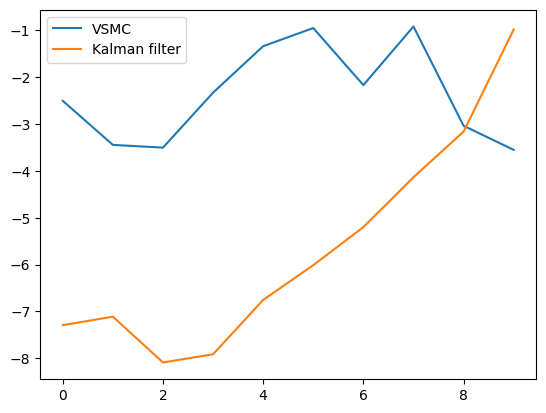

In [123]:
plt.plot(torch.tensor(x_T).numpy(), label="VSMC")
plt.plot(X_hat[-10:], label='Kalman filter')
plt.legend()

In [124]:
torch.randn(1)

tensor([-1.6841])

In [131]:
def opt_VSMC(model, data, N = 10, nIter = 500, lr = 1e-3, verbose = True):
    
    history = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for t in tqdm(range(nIter)):    
        # Run Algorithm 1 with reparameterized proposals
        _, log_w = model.run_vsmc(data, N)  # shape [T, N]
    
        # Estimate surrogate ELBO: log marginal likelihood estimate
        log_Z_est = torch.sum(torch.logsumexp(torch.tensor(log_w), dim=1) - np.log(N))  # shape [T] → scalar
    
        # Maximizing ELBO = minimizing -log_Z_est
        loss = -log_Z_est
        loss = torch.autograd.Variable(loss, requires_grad = True)
        
        optimizer.zero_grad()
        
        loss.backward()#retain_graph=True)
        optimizer.step()

        history.append(loss.detach())

        if t % 5 == 0 and verbose:
            print('iter %s:' % t, 'loss = %.3f' % loss)
    
    return history


In [147]:
# Initialize parameters randomly
param = torch.randn(1)
model = VSMC(param=param)
history = opt_VSMC(model, y, N=100, nIter=50, lr=1e-4)

  2%|▉                                           | 1/50 [00:02<02:17,  2.80s/it]

iter 0: loss = -2.256


 12%|█████▎                                      | 6/50 [00:13<01:31,  2.08s/it]

iter 5: loss = 12.567


 22%|█████████▍                                 | 11/50 [00:24<01:23,  2.15s/it]

iter 10: loss = -6.430


 32%|█████████████▊                             | 16/50 [00:35<01:19,  2.33s/it]

iter 15: loss = 7.499


 42%|██████████████████                         | 21/50 [00:47<01:08,  2.37s/it]

iter 20: loss = -1.866


 52%|██████████████████████▎                    | 26/50 [00:58<00:54,  2.25s/it]

iter 25: loss = 9.833


 62%|██████████████████████████▋                | 31/50 [01:10<00:42,  2.24s/it]

iter 30: loss = 8.048


 72%|██████████████████████████████▉            | 36/50 [01:20<00:26,  1.88s/it]

iter 35: loss = -1.504


 82%|███████████████████████████████████▎       | 41/50 [01:27<00:13,  1.51s/it]

iter 40: loss = -228.824


 92%|███████████████████████████████████████▌   | 46/50 [01:36<00:06,  1.72s/it]

iter 45: loss = 6.240


100%|███████████████████████████████████████████| 50/50 [01:42<00:00,  2.06s/it]


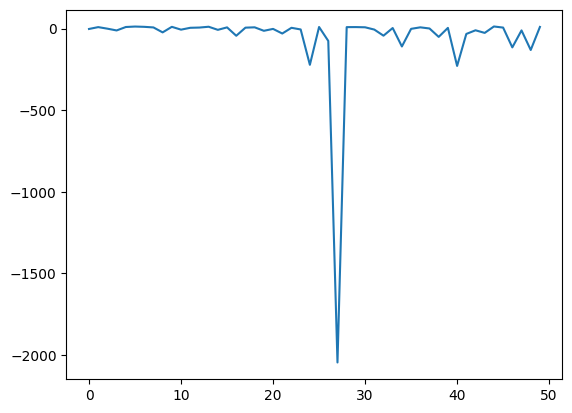

In [148]:
plt.plot(history)

In [149]:
x_T, _ = model.run_vsmc(y, 100)

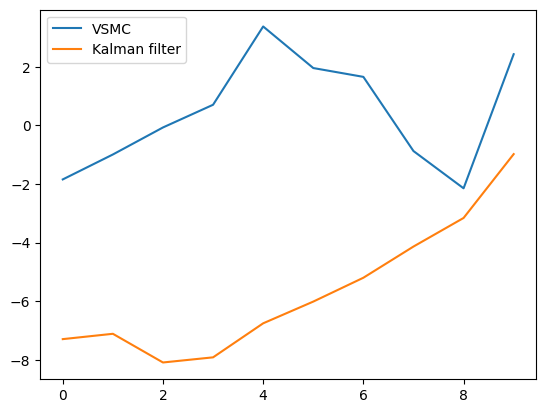

In [150]:
plt.plot(torch.tensor(x_T).numpy(), label="VSMC")
plt.plot(X_hat[-10:], label='Kalman filter')
plt.legend()

In [ ]:
N = 10  # Number of particles
T = 5  # Maximum time

for i in range(N):
    x[0,i] = r(params).sample()
    w[0,i] = f(x[0,i]) * g(y[0],x[0,i]) / r(x[0,i], params)
for t in range(1,T):
    for i in range(N):
        probs = [w[t-1,j]/(sum(w[t-1,:])) for j in range(N)]
        a[t-1,i] = distributions.Categorical(torch.tensor(probs)).sample()
        x[t,i] = r(x[t-1, a[t-1,i]],params).sample()
        x[:t, i] = [x[:t-1, a[t-1, i]], x[t,i]]
        w[t,i] = f(x[t,i], x[t-1,a[t-1,i]]) * g(y[t],x[t,i])

In [133]:
aa = torch.distributions.Categorical(torch.tensor([0.5,0.3,0.2])).sample((1000,))

sum(aa == 0)/1000,sum(aa == 1)/1000,sum(aa == 2)/1000


(tensor(0.4970), tensor(0.2950), tensor(0.2080))

## Trying again

In [209]:
a = torch.randn(100)
a

tensor([ 0.0342,  1.3397, -0.0348, -1.4512,  0.7979, -0.9922, -0.5964, -0.1032,
         1.3394, -0.3122,  0.4051,  1.3445, -0.6425, -1.1947,  1.6655, -0.7029,
        -0.1943, -0.3056, -0.0386, -0.8247,  0.0782, -0.7389, -1.1793, -0.2402,
         0.3009, -1.1995, -1.2275,  0.2868,  0.2462, -0.7707, -0.4407,  0.8648,
         1.5522,  2.2360, -1.5182, -0.8876,  1.5071, -0.0588, -0.8119,  0.3189,
        -0.8076,  0.7936,  0.0791,  0.3025, -2.3813, -1.3400,  1.0712,  0.1733,
         0.4613,  0.0799, -1.1092,  0.3714, -0.4306, -0.6195, -0.1378,  0.3529,
         1.1764,  0.6593, -0.8834,  2.2198,  1.1534,  0.3301, -1.3931, -1.8716,
         0.4820,  0.0538,  1.3028,  0.2692,  0.0979,  0.8167,  0.6504,  0.8556,
        -0.9390,  1.1247, -1.2869, -1.2644, -0.6841, -0.2953, -1.2505, -2.2516,
        -1.6836,  0.1759, -0.5421,  0.8956, -0.0475,  0.3587, -0.8750, -0.0693,
        -1.2465,  0.6521,  0.2159, -0.3390,  0.7343, -0.7211,  1.2785,  0.3438,
        -0.7447, -0.9876, -0.0551, -2.46

In [226]:
a.reshape((100,1)).reshape((100,))

tensor([ 0.0342,  1.3397, -0.0348, -1.4512,  0.7979, -0.9922, -0.5964, -0.1032,
         1.3394, -0.3122,  0.4051,  1.3445, -0.6425, -1.1947,  1.6655, -0.7029,
        -0.1943, -0.3056, -0.0386, -0.8247,  0.0782, -0.7389, -1.1793, -0.2402,
         0.3009, -1.1995, -1.2275,  0.2868,  0.2462, -0.7707, -0.4407,  0.8648,
         1.5522,  2.2360, -1.5182, -0.8876,  1.5071, -0.0588, -0.8119,  0.3189,
        -0.8076,  0.7936,  0.0791,  0.3025, -2.3813, -1.3400,  1.0712,  0.1733,
         0.4613,  0.0799, -1.1092,  0.3714, -0.4306, -0.6195, -0.1378,  0.3529,
         1.1764,  0.6593, -0.8834,  2.2198,  1.1534,  0.3301, -1.3931, -1.8716,
         0.4820,  0.0538,  1.3028,  0.2692,  0.0979,  0.8167,  0.6504,  0.8556,
        -0.9390,  1.1247, -1.2869, -1.2644, -0.6841, -0.2953, -1.2505, -2.2516,
        -1.6836,  0.1759, -0.5421,  0.8956, -0.0475,  0.3587, -0.8750, -0.0693,
        -1.2465,  0.6521,  0.2159, -0.3390,  0.7343, -0.7211,  1.2785,  0.3438,
        -0.7447, -0.9876, -0.0551, -2.46

In [279]:
def surrogate_elbo(log_w):
    log_Z_est = torch.sum(torch.logsumexp(log_w, dim=1) - math.log(N))
    return log_Z_est

In [235]:
# torch.log(N)# Normal(0, 1).log_prob(torch.tensor([0.1]))

# Now it works! (VSMC)

In [17]:
import torch
from torch.distributions import Normal

# Distributions
def prior(x, x_prev):
    if x_prev is None:
        return Normal(0,1).log_prob(x)
    else:
        return Normal(0.95*x_prev, 1).log_prob(x)

def likelihood(y_t, x_t):
    return Normal(x_t, 1).log_prob(y_t)

def proposal_logpdf(x, x_prev, lambda_):
    if x_prev is None:
        return Normal(lambda_, 1).log_prob(x)
    else:
        return Normal(lambda_ + 0.5*x_prev,1).log_prob(x)

def proposal(x_prev, eps, lambda_):
    if x_prev is None:
        mu = lambda_
    else:
        mu = lambda_ + 0.5 * x_prev
    return eps + mu


# VSMC
def run_vsmc(y_seq, lambda_, N, T):
    latent_dim = 1 #y_seq[0].size(0)
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    eps = torch.randn(N, latent_dim)
    x_t = proposal(None, eps, lambda_)
    x_particles[0] = x_t
    log_w[0] = (prior(x_t, None) + likelihood(y_seq[0], x_t) - proposal_logpdf(x_t, None, lambda_)).squeeze()

    for t in range(1, T):
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        eps = torch.randn(N, latent_dim)
        x_t = proposal(x_prev, eps, lambda_)
        x_particles[t] = x_t

        log_w[t] = (prior(x_t, x_prev) + likelihood(y_seq[t], x_t) - proposal_logpdf(x_t, x_prev, lambda_)).squeeze()

    return log_w, x_particles


def surrogate_elbo(log_w):
    logZ = torch.logsumexp(log_w, dim=1) - torch.log(torch.tensor(log_w.size(1), dtype=torch.float32))
    return logZ.sum()


In [18]:
steps = 500
T=100
y_seq = [torch.tensor(i) for i in range(T)]

# Parameter to learn
lambda_ = torch.nn.Parameter(torch.tensor([0.0]))  # shape (1,)
optimizer = torch.optim.Adam([lambda_], lr=0.1)
history = []

# Training loop
for step in range(steps):
    optimizer.zero_grad()
    log_w,_ = run_vsmc(y_seq, lambda_, N=100, T=T)
    elbo = surrogate_elbo(log_w)
    loss = -elbo
    loss.backward()
    if step % 50 == 0:
        print(f"Step {step:03d} | ELBO: {elbo.item():.2f} | grad: {lambda_.grad.item():.4f}")
    optimizer.step()
    history.append(loss)


Step 000 | ELBO: -140690.25 | grad: -8917.1152
Step 050 | ELBO: -101514.34 | grad: -7175.4038
Step 100 | ELBO: -74173.24 | grad: -5657.3945
Step 150 | ELBO: -55449.53 | grad: -4324.5225
Step 200 | ELBO: -43516.47 | grad: -3189.0044
Step 250 | ELBO: -36755.00 | grad: -2308.9021
Step 300 | ELBO: -32893.79 | grad: -1569.5050
Step 350 | ELBO: -31296.84 | grad: -1068.1907
Step 400 | ELBO: -29920.93 | grad: -687.9623
Step 450 | ELBO: -30141.77 | grad: -413.4590


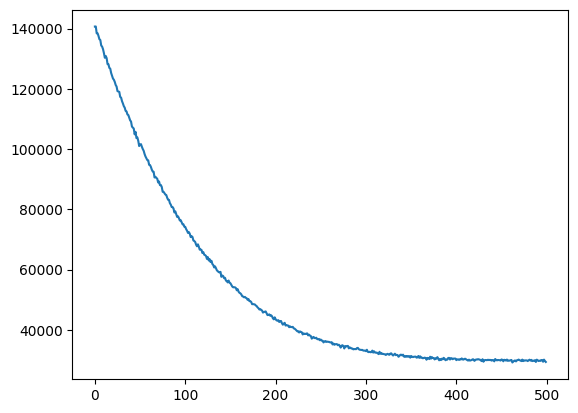

In [19]:
plt.plot([i.detach() for i in history])

In [49]:
log_w, x_vsmc = run_vsmc(y_seq, lambda_, 200, 100)
# ver se tá pegando os x's certos!!!

# Versão do mal

In [285]:
# Distributions
def prior(x, x_prev):
    if x_prev == None:
        return Normal(0,1).log_prob(x)
    else:
        return Normal(0.95*x_prev, 1).log_prob(x)


def likelihood(y_t, x_t):
    return Normal(x_t, 1).log_prob(y_t)


def proposal_logpdf(x, x_prev, lambda_):
    if x_prev is None:
        return Normal(lambda_, 1).log_prob(x)
    else:
        return Normal(lambda_ + 0.5*x_prev,1).log_prob(x)


def proposal(x_prev, eps, lambda_):
    if x_prev is None:
        mu = lambda_
    else:
        mu = lambda_ + 0.5 * x_prev
    return eps + mu


# VSMC
def run_vsmc(y_seq, lambda_, N, T):
    '''
    y_seq: list of torch.tensor's 
    '''
    latent_dim = 1 #y_seq[0].size(0)
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    eps = torch.randn(N, latent_dim)
    x_t = proposal(None, eps, lambda_)
    x_particles[0] = x_t
    log_w[0] = (prior(x_t, None) + likelihood(y_seq[0], x_t) - proposal_logpdf(x_t, None, lambda_)).squeeze()
    
    for t in range(1, T):
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        eps = torch.randn(N, latent_dim)
        x_t = proposal(x_prev, eps, lambda_)
        x_particles[t] = x_t

        cur_log_w = (
            prior(x_t, x_prev)
            + likelihood(y_seq[t], x_t)
            - proposal_logpdf(x_t, x_prev, lambda_)
        )
        log_w[t] = cur_log_w.reshape((N,))

    return log_w, x_particles, ancestors


In [286]:
num_epochs = 100
T = 100
N = 1000
lambda_ = nn.Parameter(torch.randn(N,), requires_grad=True)

y_seq = [torch.tensor([i]) for i in Y]
optimizer = torch.optim.Adam([lambda_], lr=1e-4)

history = []

for epoch in tqdm(range(num_epochs)):
    log_w, _, _ = run_vsmc(y_seq, lambda_, N, T)
    elbo = surrogate_elbo(log_w)
    loss = -elbo  # Maximize ELBO
    loss = torch.autograd.Variable(loss, requires_grad = True)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(lambda_.grad)

    history.append(loss)

  0%|                                                   | 0/100 [00:00<?, ?it/s]


RuntimeError: The expanded size of the tensor (1) must match the existing size (1000) at non-singleton dimension 1.  Target sizes: [1000, 1].  Tensor sizes: [1000, 1000]

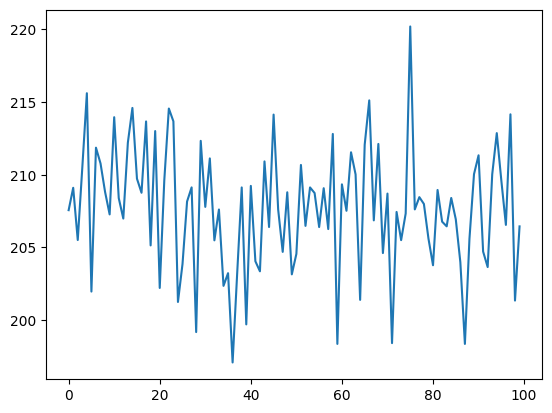

In [247]:
plt.plot([i.detach() for i in history])

# Normalizing Flow

---

# References

\[1\] T. Lacey, "Tutorial: The Kalman Filter". Accessed: Jul. 09, 2025. \[Online\]. Available: https://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf.

\[2\] C. A. Naesseth, S. W. Linderman, R. Ranganath, and D. M. Blei, "Variational Sequential Monte
Carlo." \[Online\]. Available: https://arxiv.org/abs/1705.11140.